In [12]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 16 16:20:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    25W /  70W |   9066MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
#Import Stuff here

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, DepthwiseConv2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import time
from datetime import datetime
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop


In [14]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)


In [15]:
from google.colab import drive, files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
def load_data():

    datagen = ImageDataGenerator(rescale = 1/255)
    
    train_it = datagen.flow_from_directory ('/content/drive/My Drive/Colab Notebooks/IFFI-dataset-raw/resized/', target_size = (256, 256), 
                                            class_mode = 'categorical', color_mode="rgb", batch_size=64, seed = 1)
    
    val_it = datagen.flow_from_directory ('/content/drive/My Drive/Colab Notebooks/IFFI-dataset-raw/validation/', target_size = (256, 256), 
                                            class_mode = 'categorical', color_mode="rgb", batch_size=64, seed = 1)
    
    test_it = datagen.flow_from_directory ('/content/drive/My Drive/Colab Notebooks/IFFI-dataset-raw/test/', target_size = (256, 256), 
                                            class_mode = 'categorical', color_mode="rgb", batch_size=64, seed = 1,  shuffle=False)
    
    return train_it, val_it, test_it

train_it, val_it, test_it = load_data()

Found 6800 images belonging to 17 classes.
Found 1700 images belonging to 17 classes.
Found 1700 images belonging to 17 classes.


In [17]:
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(64, 256, 256, 3), min=0.000, max=1.000


In [18]:
from keras.applications.vgg16 import VGG16
# load model
#model = VGG16()
# summarize the model
#model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 17)                8721      
                                                                 
Total params: 14,723,409
Trainable params: 8,721
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


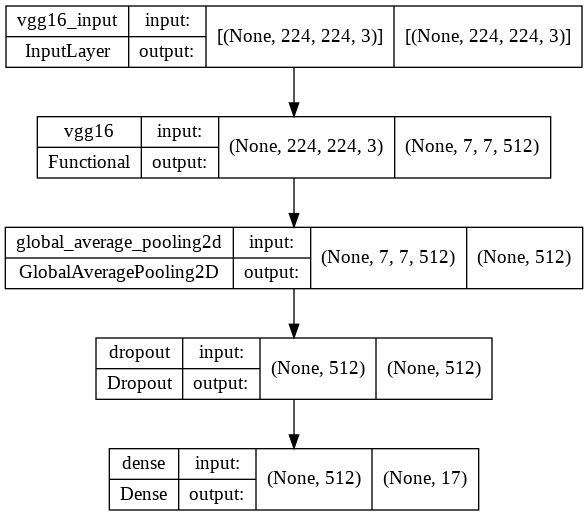

In [8]:
# Base Model

nclass = len(train_it.class_indices)

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
                          include_top = False, # Leave out the last fully connected Layer
                          weights = 'imagenet',
                          classes = nclass)
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, 
                                       momentum=0.9),
              metrics=['accuracy'])
model.summary()
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [10]:
# Adding layers

nclass = len(train_it.class_indices)

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
                          include_top = False, # Leave out the last fully connected Layer
                          weights = 'imagenet',
                          classes = nclass)
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)

#add_model.add(Flatten())
add_model.add(GlobalAveragePooling2D())

add_model.add(Dense(512, activation = 'relu'))
add_model.add(Dropout(0.2))

add_model.add(Dense(256, activation = 'relu'))
add_model.add(Dropout(0.2))

add_model.add(Dense(128, activation = 'relu'))
add_model.add(Dropout(0.2))

add_model.add(Dense(64, activation = 'relu'))
add_model.add(Dropout(0.2))

add_model.add(Dense(nclass, activation='softmax'))


model = add_model


In [7]:
# keep 3 layers of vgg16

def build_model(fine_tune = 0):
    base_model = VGG16 (input_shape = (256, 256, 3), include_top = False, weights = 'imagenet', classes = 17)
    if fine_tune > 0:
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(2048, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation = 'relu')(x)
    my_output = Dropout (0.2)(x)
    probs = Dense(17, activation = 'softmax')(my_output)
    model = keras.Model(base_model.input, outputs=probs)
    model.summary()
    return model
model = build_model(fine_tune=3)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [19]:
# Fine-tune
# Part 1: Pre train

nclass = len(train_it.class_indices)

# create the base pre-trained model
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
                          include_top = False, # Leave out the last fully connected Layer
                          weights = 'imagenet',
                          classes = nclass)
#base_model.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(nclass, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

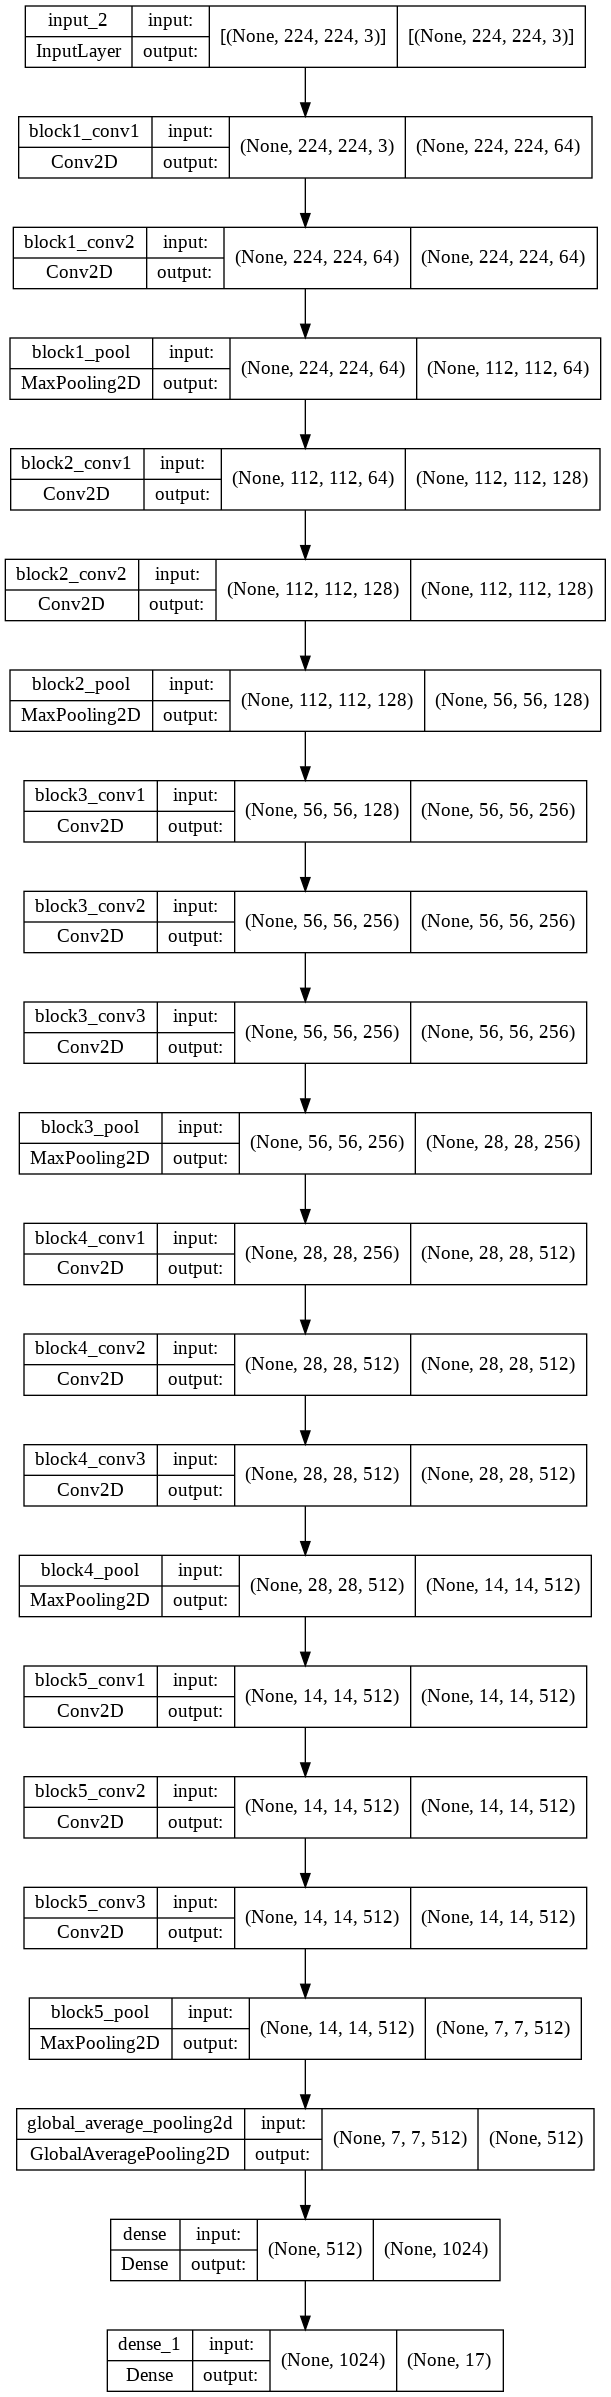

In [10]:
model.compile(loss='categorical_crossentropy', 
              # optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              optimizer = 'Adam',
              metrics=['AUC', 'accuracy'])
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [20]:
def compile_model(model):
  
  model.compile(optimizer = 'Adam',
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=['AUC', 'accuracy'])
  
  return model

def train_model(model, train_it, val_it):

    callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 5, restore_best_weights = True)
    history = model.fit(train_it, epochs = 24, steps_per_epoch = 107, verbose = 2, validation_data= val_it, validation_steps = 27, callbacks=[callback])
    return model, history
 
model = compile_model(model)

model, history = train_model(model, train_it, val_it)
print (model.summary())

Epoch 1/24
107/107 - 87s - loss: 2.5946 - auc: 0.6918 - accuracy: 0.1909 - val_loss: 2.3050 - val_auc: 0.8003 - val_accuracy: 0.2494 - 87s/epoch - 809ms/step
Epoch 2/24
107/107 - 84s - loss: 2.1038 - auc: 0.8412 - accuracy: 0.3334 - val_loss: 2.0237 - val_auc: 0.8471 - val_accuracy: 0.3512 - 84s/epoch - 785ms/step
Epoch 3/24
107/107 - 84s - loss: 1.8572 - auc: 0.8807 - accuracy: 0.4066 - val_loss: 1.9049 - val_auc: 0.8658 - val_accuracy: 0.3747 - 84s/epoch - 785ms/step
Epoch 4/24
107/107 - 84s - loss: 1.7235 - auc: 0.8978 - accuracy: 0.4449 - val_loss: 1.8851 - val_auc: 0.8684 - val_accuracy: 0.3841 - 84s/epoch - 789ms/step
Epoch 5/24
107/107 - 85s - loss: 1.6322 - auc: 0.9094 - accuracy: 0.4622 - val_loss: 1.8277 - val_auc: 0.8783 - val_accuracy: 0.4065 - 85s/epoch - 790ms/step
Epoch 6/24
107/107 - 85s - loss: 1.5509 - auc: 0.9192 - accuracy: 0.4884 - val_loss: 1.7940 - val_auc: 0.8840 - val_accuracy: 0.4029 - 85s/epoch - 791ms/step
Epoch 7/24
107/107 - 85s - loss: 1.4901 - auc: 0.925

In [21]:
def eval_model(model, test_it):
    # TODO: evaluate the model

    test_loss, test_auc, test_accuracy = model.evaluate (test_it, steps = 27)

    return test_loss, test_auc, test_accuracy

test_loss, test_auc, test_accuracy = eval_model(model, test_it)

27/27 [==============================] - 848s 33s/step - loss: 2.2081 - auc: 0.8598 - accuracy: 0.4265


In [22]:
test_it.reset()
preds = model.predict(test_it, steps = 27)

In [23]:
y_predict = np.argmax(preds,axis=1)

In [24]:
print(classification_report(test_it.classes, y_predict, target_names=test_it.class_indices))

              precision    recall  f1-score   support

        1977       0.36      0.49      0.41       100
       Amaro       0.38      0.19      0.25       100
     Brannan       0.34      0.59      0.43       100
   Clarendon       0.26      0.27      0.26       100
     Gingham       0.26      0.35      0.30       100
       He-Fe       0.53      0.09      0.15       100
      Hudson       0.32      0.50      0.39       100
       Lo-Fi       0.30      0.45      0.36       100
     Mayfair       0.23      0.18      0.20       100
   Nashville       0.78      0.80      0.79       100
    Original       0.28      0.19      0.23       100
    Perpetua       0.40      0.38      0.39       100
       Sutro       0.70      0.46      0.55       100
     Toaster       0.49      0.83      0.61       100
    Valencia       0.39      0.14      0.21       100
      Willow       0.89      0.95      0.92       100
     X-ProII       0.70      0.39      0.50       100

    accuracy              

In [25]:
y_predict

array([ 6,  0,  4, ..., 16, 12,  1])

In [26]:
error_count = 0

for x in y_predict:
    if y_predict[x] != test_it.classes[x]:
        error_count += 1
        
error_count

973

In [27]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

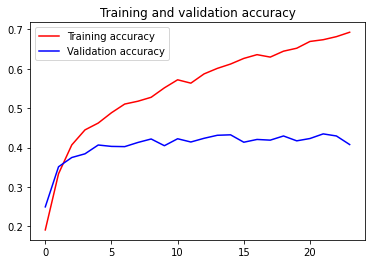

<Figure size 432x288 with 0 Axes>

In [28]:
plot_result(history)

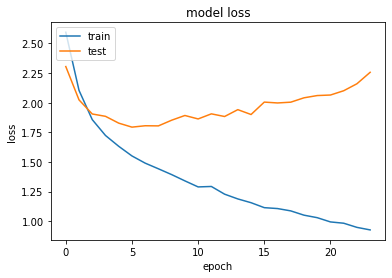

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
#Fine-Tune part 2
# Visualize layer names and layer indices to see how many layers need to be freeze
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [31]:
# we chose to train the top 2 blocks, try freeze the first 9 layers and unfreeze the rest:
for layer in model.layers[:3]:
   layer.trainable = False
for layer in model.layers[3:]:
   layer.trainable = True

In [32]:
# we need to recompile the model for these modifications to take effect
# try a low learning rate
model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['AUC', 'accuracy'])

In [39]:

# Train our model again (fine-tuning the top 2 blocks alongside the top Dense layers
model, history = train_model(model, train_it, val_it)
print (model.summary())

Epoch 1/24
107/107 - 132s - loss: 0.1305 - auc: 0.9989 - accuracy: 0.9543 - val_loss: 0.7686 - val_auc: 0.9688 - val_accuracy: 0.8400 - 132s/epoch - 1s/step
Epoch 2/24
107/107 - 133s - loss: 0.0551 - auc: 0.9997 - accuracy: 0.9809 - val_loss: 1.0848 - val_auc: 0.9566 - val_accuracy: 0.7753 - 133s/epoch - 1s/step
Epoch 3/24
107/107 - 132s - loss: 0.0355 - auc: 0.9999 - accuracy: 0.9888 - val_loss: 1.2553 - val_auc: 0.9496 - val_accuracy: 0.8053 - 132s/epoch - 1s/step
Epoch 4/24
107/107 - 133s - loss: 0.0337 - auc: 0.9999 - accuracy: 0.9900 - val_loss: 1.0623 - val_auc: 0.9567 - val_accuracy: 0.8076 - 133s/epoch - 1s/step
Epoch 5/24
107/107 - 132s - loss: 0.1126 - auc: 0.9989 - accuracy: 0.9651 - val_loss: 0.9364 - val_auc: 0.9605 - val_accuracy: 0.8418 - 132s/epoch - 1s/step
Epoch 6/24
107/107 - 132s - loss: 0.0844 - auc: 0.9995 - accuracy: 0.9704 - val_loss: 1.1238 - val_auc: 0.9544 - val_accuracy: 0.8159 - 132s/epoch - 1s/step
Epoch 7/24
107/107 - 132s - loss: 0.0076 - auc: 1.0000 - a

In [40]:
test_loss, test_auc, test_accuracy = eval_model(model, test_it)

27/27 [==============================] - 45s 2s/step - loss: 0.6790 - auc: 0.9717 - accuracy: 0.8624


In [41]:
test_it.reset()
preds = model.predict(test_it, steps = 27)
y_predict = np.argmax(preds,axis=1)
print(classification_report(test_it.classes, y_predict, target_names=test_it.class_indices))

              precision    recall  f1-score   support

        1977       0.91      0.96      0.93       100
       Amaro       0.70      0.88      0.78       100
     Brannan       0.91      0.94      0.93       100
   Clarendon       0.68      0.82      0.75       100
     Gingham       0.80      0.85      0.83       100
       He-Fe       0.87      0.92      0.89       100
      Hudson       0.94      0.83      0.88       100
       Lo-Fi       0.78      0.73      0.76       100
     Mayfair       0.73      0.82      0.77       100
   Nashville       0.93      0.99      0.96       100
    Original       0.86      0.63      0.73       100
    Perpetua       0.97      0.84      0.90       100
       Sutro       0.97      0.91      0.94       100
     Toaster       0.96      0.97      0.97       100
    Valencia       0.94      0.59      0.72       100
      Willow       1.00      1.00      1.00       100
     X-ProII       0.85      0.98      0.91       100

    accuracy              

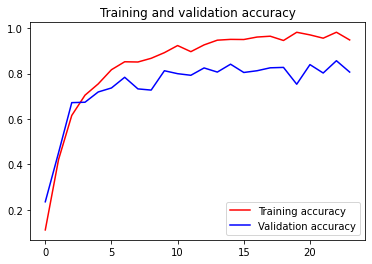

<Figure size 432x288 with 0 Axes>

In [36]:
plot_result(history)

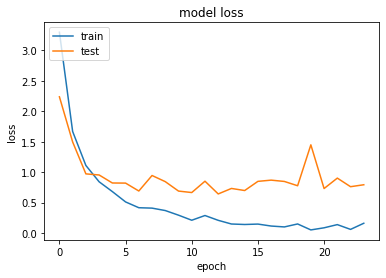

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
model.save('/content/drive/My Drive/Colab Notebooks/VGG16.h5', overwrite = True,
           include_optimizer=True)